# Stochastic Physics-Informed Neural ODEs (SPINODE)

A few key notes:

(1) The code here is tailored to learn neural network representations of hidden physics within stochastic differential equations of the form:

$$ dx = g_1(x,u)dt + \sqrt{2g_2(x,u)} dw, $$

where where $x$ is the system state, $u$ is an exogenous input, $w$ is a Gaussian white noise process, $g_1$ is the drift coefficient, and $g_2$ is the diffusion coefficient. Although the drift and diffusion coefficients represent the underlying physics of the stochastic system, these coefficients may not be known or even measurable in practice. As a result, $g_1$, $g_2$, or individual functions that contribute to $g_1$ and $g_2$ can comprise the the hidden physics of the above equation.

(2) The code uses unscented transform to propagate stochasticity through the above equations although other uncertainty propagation methods can be integrated into the code.

(3) Example data and results are provided for the first case study from the original paper (O'Leary et al., 2022) in the file Data.zip. The first case study is a two-state model for directed colloidal self-assembly with an exogenous input.

In [1]:
# !rm -rf /content/LVE/Train

In [2]:
!pip install torchdiffeq

In [3]:
# Do not write bytecode to maintain clean directories
import sys
sys.dont_write_bytecode = True

# Import required packages and core code
import numpy as np
import os
import torch
import train

# Specify GPU or CPU use
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Load moment data
# Mean data must be of shape [N, [nx,nu], 1]
# Covariance data must be of shape [N, nx, nx]
# Note that the general methodology can handle higher moments
# --> This code, however, only uses mean and covariance data

mean_i = np.load("LVE/data/mean_initial.npy") # mean at time step k
mean_f = np.load("LVE/data/mean_final.npy") # mean at time step k + 1
cov_i = np.load("LVE/data/cov_initial.npy") # covariance at time step k
cov_f = np.load("LVE/data/cov_final.npy") # covariance at time step k + 1

In [5]:
# Enter relevant system information
nx = 2 # state dimension
nw = 2 # noise dimension
n = nx + nw # augmented state dimension
nu = 0 # exogenous input dimension
dt = 0.01 # sampling time

In [6]:
# Prepare some of the data used to train the neural networks
# that approximate the hidden physics. Note that the "sigma" points come from
# the unscented transform function defined in "utils.py"

# First choose and create path where data will be saved
path = "LVE/Train/"
os.makedirs(path)

# Now prepare data
[sigma_train,
 sigma_val,
 sigma_test,
 mean_f_train,
 mean_f_val,
 mean_f_test,
 cov_f_train,
 cov_f_val,
 cov_f_test,
 W_train,
 W_val,
 W_test,
 sigma_mu,
 sigma_std] = train.prep_data(mean_i,
                              cov_i,
                              mean_f,
                              cov_f,
                              nx,
                              nu,
                              nw,
                              path)

In [7]:
# Set training parameters for neural network that approximates g1
hidden_dim_g1 = 100 # number of hidden nodes
num_hidden_layers_g1 = 2 # number of hidden layers
num_epoch_g1 = 500 # number of epochs
solver_g1 = 'euler' # ode solver
# Note that for the provided data, the 'euler' ODE solver performs the best.
# See O'Leary, et al., 2022 for more details
rtol_g1 = 1e-7 # default value 1e-7
atol_g1 = 1e-9 # default value 1e-9

In [8]:
# Train neural network that approximates g1
model_g1 = train.train_g1(hidden_dim_g1,
                          num_hidden_layers_g1,
                          device,
                          nx,
                          nu,
                          dt,
                          num_epoch_g1,
                          sigma_train,
                          sigma_val,
                          mean_f_train,
                          mean_f_val,
                          W_train,
                          W_val,
                          solver_g1,
                          rtol_g1,
                          atol_g1,
                          path)

Epoch 0000 | Train Loss 0.000024528 | Val Loss 0.000017600
0.3223235607147217
Epoch 0001 | Train Loss 0.000018675 | Val Loss 0.000012962
0.0952463150024414
Epoch 0002 | Train Loss 0.000014144 | Val Loss 0.000009469
0.0946509838104248
Epoch 0003 | Train Loss 0.000010654 | Val Loss 0.000007142
0.10136556625366211
Epoch 0004 | Train Loss 0.000009091 | Val Loss 0.000005896
0.09204530715942383
Epoch 0005 | Train Loss 0.000008168 | Val Loss 0.000005359
0.09044337272644043
Epoch 0006 | Train Loss 0.000006624 | Val Loss 0.000005331
0.09329104423522949
Epoch 0007 | Train Loss 0.000006705 | Val Loss 0.000005574
0.09423208236694336
Epoch 0008 | Train Loss 0.000007401 | Val Loss 0.000005805
0.09032487869262695
Epoch 0009 | Train Loss 0.000007076 | Val Loss 0.000005742
0.09839701652526855
Epoch 0010 | Train Loss 0.000006978 | Val Loss 0.000005570
0.09155607223510742
Epoch 0011 | Train Loss 0.000006245 | Val Loss 0.000005214
0.09137678146362305
Epoch 0012 | Train Loss 0.000006547 | Val Loss 0.000004

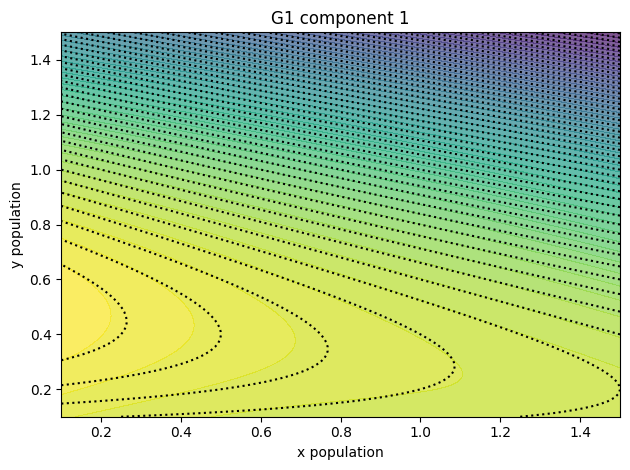

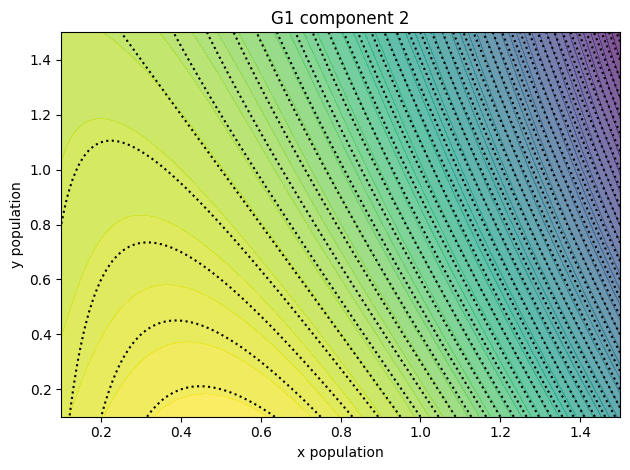

In [9]:
# Reconstruct g1
rmse_g1 = train.reconstruct_LVE('g1',
                                model_g1,
                                device,
                                sigma_mu,
                                sigma_std,
                                nx,
                                nu,
                                dt,
                                path)

In [10]:
# Set training parameters for neural network that approximates g2
hidden_dim_g2 = 100 # number of hidden nodes
num_hidden_layers_g2 = 2 # number of hidden layers
num_epoch_g2 = 500 # number of epochs
solver_g2 = 'euler' # ode solver
# Note that for the provided data, the 'euler' ODE solver performs the best.
# See O'Leary, et al., 2022 for more details
rtol_g2 = 1e-15 # default value 1e-7
atol_g2 = 1e-15 # default value 1e-9

In [11]:
# Prepare target data for training neural network that approximates g2
[g2_target_train,
 g2_target_val,
 g2_target_test] = train.calc_g2_targets(sigma_train,
                                         sigma_val,
                                         sigma_test,
                                         mean_f_train,
                                         mean_f_val,
                                         mean_f_test,
                                         cov_f_train,
                                         cov_f_val,
                                         cov_f_test,
                                         nx,
                                         nu,
                                         nw,
                                         dt,
                                         sigma_mu,
                                         sigma_std,
                                         W_train,
                                         W_val,
                                         W_test,
                                         model_g1,
                                         device,
                                         solver_g1,
                                         rtol_g1,
                                         atol_g1,
                                         path)

In [12]:
# Train neural network that approximates g2
model_g2 = train.train_g2(hidden_dim_g2,
                          num_hidden_layers_g2,
                          device,
                          nx,
                          nu,
                          dt,
                          num_epoch_g2,
                          sigma_train,
                          sigma_val,
                          g2_target_train,
                          g2_target_val,
                          solver_g2,
                          rtol_g2,
                          atol_g2,
                          path)

Epoch 0000 | Train Loss 0.000000582 | Val Loss 0.000000147
0.015503406524658203
Epoch 0001 | Train Loss 0.000000089 | Val Loss 0.000000395
0.013241291046142578
Epoch 0002 | Train Loss 0.000000246 | Val Loss 0.000000302
0.012748956680297852
Epoch 0003 | Train Loss 0.000000146 | Val Loss 0.000000100
0.012766361236572266
Epoch 0004 | Train Loss 0.000000054 | Val Loss 0.000000073
0.01269984245300293
Epoch 0005 | Train Loss 0.000000080 | Val Loss 0.000000102
0.01266932487487793
Epoch 0006 | Train Loss 0.000000086 | Val Loss 0.000000087
0.012588262557983398
Epoch 0007 | Train Loss 0.000000052 | Val Loss 0.000000074
0.012629032135009766
Epoch 0008 | Train Loss 0.000000039 | Val Loss 0.000000080
0.012702465057373047
Epoch 0009 | Train Loss 0.000000045 | Val Loss 0.000000072
0.012592792510986328
Epoch 0010 | Train Loss 0.000000041 | Val Loss 0.000000049
0.014210939407348633
Epoch 0011 | Train Loss 0.000000034 | Val Loss 0.000000042
0.01270604133605957
Epoch 0012 | Train Loss 0.000000029 | Val L

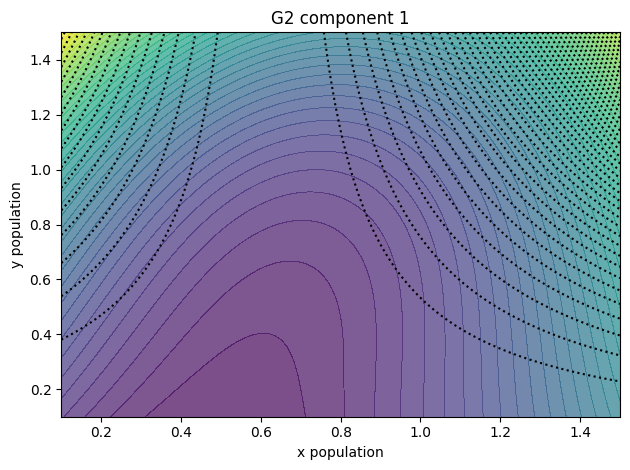

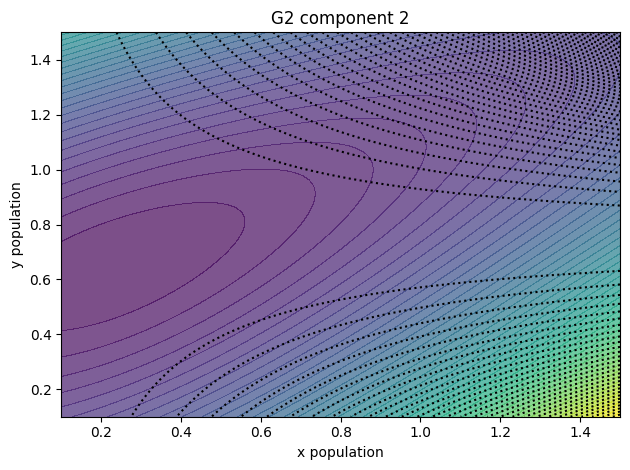

In [13]:
# Reconstruct g2
rmse_g2 = train.reconstruct_LVE('g2',
                                model_g2,
                                device,
                                sigma_mu,
                                sigma_std,
                                nx,
                                nu,
                                dt,
                                path)

In [14]:
import numpy as np
rmse_g1 = np.load("LVE/Train/rmse_g1_LVE.npy")
rmse_g2 = np.load("LVE/Train/rmse_g2_LVE.npy")
print("RMSE(g1):", rmse_g1)
print("RMSE(g2):", rmse_g2)

RMSE(g1): 0.023690901234367144
RMSE(g2): 0.024435821536803102


___

In [15]:
import os
import zipfile
from google.colab import files

# La ruta de la carpeta que quieres descargar
folder_to_download = 'LVE/Train/'

# Obtener el nombre base de la carpeta para el archivo ZIP
# os.path.normpath maneja las barras finales y os.path.basename extrae el último componente
base_folder_name = os.path.basename(os.path.normpath(folder_to_download))
zip_file_name = f'{base_folder_name}.zip'

# Crear un archivo ZIP de la carpeta
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for root, dirs, files_in_folder in os.walk(folder_to_download):
        for file in files_in_folder:
            # Crea una ruta relativa para el archivo dentro del ZIP
            arcname = os.path.relpath(os.path.join(root, file), folder_to_download)
            zipf.write(os.path.join(root, file), arcname)

# Descargar el archivo ZIP
print(f'Comprimiendo {folder_to_download} en {zip_file_name} y descargando...')
files.download(zip_file_name)
print('¡Descarga completada!')

Comprimiendo LVE/Train/ en Train.zip y descargando...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

¡Descarga completada!
